# Problem 1 Implement a simple regression tree. 
We will use point estimates in the leaves
and use the CART Variance Reduction measure for a splitting criteria.

$$ VR(S) = var S − \sum_{i=0}^{K}{\frac{|S_i|}{|S|}var S_i}$$
Use the attached code as your starting point.



In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_test_data(N):
    x = np.random.randn(N, 5)
    y = np.where(x[:, 0] > 0, 2, 5)
    y = y + np.where(x[:, 1] > 0, -3, 3)
    y = y + np.where(x[:, 2] > 0, 0, 0.5)
    y = y + 10 * np.random.randn(N)
    return x,y 

class TreeNode:
    def predict(x, y):
        assert False

    def depth(self):
        assert False

class BranchNode(TreeNode):
    def __init__(self, left, right, split_var_index, split_var_value):
        self.left = left
        self.right = right
        self.split_var_index = split_var_index
        self.split_var_value = split_var_value

    def predict(self, x):
        svar = x[:, self.split_var_index]
        is_left = svar < self.split_var_value
        leftx = x[is_left]
        rightx = x[~is_left]

        rv = np.zeros(x.shape[0])
        rv[is_left] = self.left.predict(leftx)
        rv[~is_left] = self.right.predict(rightx)

        return rv

    def depth(self):
        return 1 + max(self.left.depth(), self.right.depth())

class LeafNode(TreeNode):
    def __init__(self, mu):
        self.mu = mu

    def predict(self, x):
        return np.repeat(self.mu, x.shape[0])

    def depth(self):
        return 1

class RegressionTree:
    def __init__(self, max_depth, min_points_in_leaf):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)

    def fit_internal(self, x, y, current_depth):
        # implement this
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        best_var_reduction = 0
        best_split_point = None
        # Here, we have to loop over all features and figure out which one
        # might be splittable, and if it is, how to split it to maximize Variance Reduction
        for i in range(num_features):
            # a lot of code goes here
            x_i = x[:,i]
            x_i_min = np.min(x_i)
            bin_size = (np.max(x_i) - x_i_min)/5
            split_point_list = [x_i_min + i * bin_size for i in range(1,5)]
            for split_point in split_point_list:
                is_left = x_i < split_point
                left_size = len(x_i[is_left])
                right_size = len(x_i[~is_left])
                total_size = left_size + right_size
                if left_size < self.min_points_in_leaf or right_size < self.min_points_in_leaf:
                    # not splittable
                    continue
                else:
                    var_reduction = var_orig - left_size / total_size * np.var(y[is_left]) - right_size / total_size * np.var(y[~is_left])
                    if best_var_reduction < var_reduction:
                        best_var_reduction = var_reduction
                        best_variable = i
                        best_split_point = split_point

        
        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            #return BranchNode(....) FILL THIS IN
            is_left = x[:, best_variable] < best_split_point
            return BranchNode(self.fit_internal(x[is_left,:], y[is_left],current_depth+1), 
                              self.fit_internal(x[~is_left,:], y[~is_left],current_depth+1),
                              best_variable, best_split_point)

    def depth(self):
        return self.root.depth()

## In and Out-sample test against different max depths and report a graph of depth vs  $R^2$
- For simplicity’s sake, divide each attribute up into 5 equal sized bins, and test each end point of a bin as a potential split point. Test your algorithm on a 50000 row dataset generated using the attached generate test data function. Test against different max depths and report a graph of depth vs $R^2$. Now, on the same graph, plot $R^2$ where you are using a new dataset, generated independently of the one used to train the tree. Does it look different? Why?

## Solution: 
- The graph of R square vas max depth looks different between in sample and out sample data when we augmented the noise with a multiply of 10.
Because as the max depth of regression tree grows, it tends to overfit the noise generated in train set. In consequence, it doesn't generalize well to the independently generated test set.

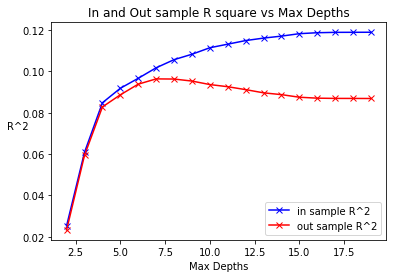

In [3]:
x_in, y_in = generate_test_data(50000)
x_out, y_out = generate_test_data(50000)

R_square_in = []
R_square_out = []
for i in range(2,20):
    Rtree = RegressionTree(i, 100)
    Rtree.fit(x_in,y_in)
    R_square_in.append(1 - np.var(Rtree.predict(x_in) - y_in) / np.var(y_in))
    R_square_out.append(1 - np.var(Rtree.predict(x_out) - y_out) / np.var(y_out))
    
plt.plot(np.arange(2,20), R_square_in, '-bx', label="in sample R^2")
plt.plot(np.arange(2,20), R_square_out, '-rx', label="out sample R^2")
plt.xlabel("Max Depths")
plt.ylabel("R^2", rotation= 0)
plt.title("In and Out sample R square vs Max Depths")
plt.legend()
plt.show()

## Use cross-validation when calculating variance reduction

- One way to potentially improve this and avoid overfitting would be to use crossvalidation when calculating variance reduction. Modify your tree to have the constructor to take a num_cv_folds parameter. If this value is > 1, then calculate the variance reduction on a cross-validated dataset instead, ie for each candidate split point you are considering, you should do a CV measurement of the variance reduction. ONLY SPLIT if the CV Variance Reduction is positive. Repeat the experiments from the first part of the question and discuss any differences.

## Solution:
- After cross validation, we can see that there is no longer big difference between in sample and out sample R square.

In [4]:
class RegressionTree_CV:
    def __init__(self, max_depth, min_points_in_leaf, num_cv_folds):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf
        self.num_cv_folds = num_cv_folds

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)

    def fit_internal(self, x, y, current_depth):
        # implement this
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        best_var_reduction = 0
        best_split_point = None
        # Here, we have to loop over all features and figure out which one
        # might be splittable, and if it is, how to split it to maximize Variance Reduction
        for i in range(num_features):
            # a lot of code goes here
            x_i = x[:,i]     
            x_i_min = np.min(x_i)
            bin_size = (np.max(x_i) - x_i_min) / 5
            split_point_list = [x_i_min + m * bin_size for m in range(1,5)]
            if self.num_cv_folds > 1:
                CV_measure = np.zeros(4)
                x_i_dividable = x_i[:int(num_rows / self.num_cv_folds)*self.num_cv_folds]
                y_dividable = y[:int(num_rows / self.num_cv_folds)*self.num_cv_folds]
                x_k_list = np.split(x_i_dividable, self.num_cv_folds)
                y_k_list = np.split(y_dividable, self.num_cv_folds)
                for k in range(self.num_cv_folds):
                    x_cv = x_k_list[k]
                    y_cv = y_k_list[k]
                    x_train = np.vstack(x_k_list[:k]+x_k_list[(k+1):])
                    x_train_min = np.min(x_train)
                    bin_size = (np.max(x_train) - x_train_min) / 5
                    split_point_list_for_train = [x_train_min + m * bin_size for m in range(1,5)]
                    j = 0
                    for split_point in split_point_list_for_train:
                        is_left = x_cv < split_point
                        left_size = len(x_cv[is_left])
                        right_size = len(x_cv[~is_left])
                        total_size = left_size + right_size
                        if left_size < self.min_points_in_leaf or right_size < self.min_points_in_leaf:
                            # not splittable
                            continue
                        else:      
                            CV_measure[j] += var_orig - left_size / total_size * np.var(y_cv[is_left]) - right_size / total_size * np.var(y_cv[~is_left])
                            j += 1
                CV_measure = CV_measure / k
                var_reduction = np.max(CV_measure)
                if best_var_reduction < var_reduction:
                    best_var_reduction = var_reduction
                    best_variable = i
                    best_split_point = split_point_list[np.argmax(CV_measure)] 
                
            else:
                for split_point in split_point_list:
                    is_left = x_i < split_point
                    left_size = len(x_i[is_left])
                    right_size = len(x_i[~is_left])
                    total_size = left_size + right_size
                    if left_size < self.min_points_in_leaf or right_size < self.min_points_in_leaf:
                        # not splittable
                        continue
                    else:      
                        var_reduction = var_orig - left_size / total_size * np.var(y[is_left]) - right_size / total_size * np.var(y[~is_left])
                        if best_var_reduction < var_reduction:
                            best_var_reduction = var_reduction
                            best_variable = i
                            best_split_point = split_point

        
        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            #return BranchNode(....) FILL THIS IN
            is_left = x[:, best_variable] < best_split_point
            return BranchNode(self.fit_internal(x[is_left,:], y[is_left],current_depth+1), 
                              self.fit_internal(x[~is_left,:], y[~is_left],current_depth+1),
                              best_variable, best_split_point)

    def depth(self):
        return self.root.depth()

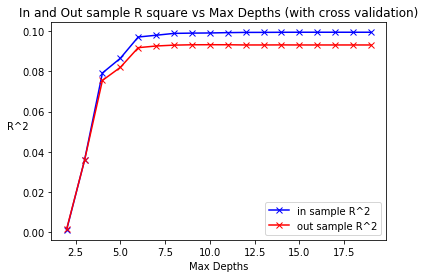

In [6]:
x_in, y_in = generate_test_data(50000)
x_out, y_out = generate_test_data(50000)

R_square_in = []
R_square_out = []
for i in range(2,20):
    Rtree = RegressionTree_CV(i, 100, 10)
    Rtree.fit(x_in,y_in)
    R_square_in.append(1 - np.var(Rtree.predict(x_in) - y_in) / np.var(y_in))
    R_square_out.append(1 - np.var(Rtree.predict(x_out) - y_out) / np.var(y_out))
    
plt.plot(np.arange(2,20), R_square_in, '-bx', label="in sample R^2")
plt.plot(np.arange(2,20), R_square_out, '-rx', label="out sample R^2")
plt.xlabel("Max Depths")
plt.ylabel("R^2", rotation = 0)
plt.title("In and Out sample R square vs Max Depths (with cross validation)")
plt.legend()
plt.show()